### 1.1 Datensatz vorbereiten

Teile des Codes sind aus dem Projekt "fine_tuning_huggingface" aus der Übung für Informationswissenschaft 2

In [ ]:
!pip install datasets transformers
!pip install accelerate
!pip install evaluate datasets transformers

In [ ]:
import evaluate
from datasets import load_dataset, Dataset, DatasetDict
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from evaluate import evaluator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Entfernen von HTML und XML Tags

In [ ]:
def remove_xml_tags(review_text):
  if isinstance(review_text, str):
    return BeautifulSoup(review_text, "lxml").text
  else:
    return "" # Return an empty string for non-string values

Das Mapping ist bei diesem Datensatz ist nötig, da die CSV Datei im Standardformat als float gespeichert wird, und dieses in Integer umgewandelt werden muss.

In [ ]:
# Label-Mapping definieren
label_mapping = {0 : 0, 1 : 1, 2 : 2}

# Funktion für das Mapping von String zu Integer erstellen
def map_label(label):
    return label_mapping.get(label)

Dieser Code dient dazu, Serviceposts von Bluesky im Vorfeld zu entfernen, da diese für das Ergebnis nicht relevant sind

In [ ]:
# CSV-Datei einlesen
df = pd.read_csv('/content/filtered_feeds_test3.csv')


# Beispiel 2: Zeilen entfernen, die bestimmte Wörter oder Phrasen enthalten (z. B. "uninteressant", "test")
uninteressante_woerter = ['Trending Words', 'past usage']
df = df[~df['text'].str.contains('|'.join(uninteressante_woerter), na=False)]

# Ergebnis speichern (optional)
df.to_csv('/content/bereinigte_datei.csv', index=False)

In [ ]:
bluesky_tweet_dataset = pd.read_csv("/content/bereinigte_datei.csv",
                                    delimiter=",",
                                    encoding='utf-8',
                                    names=['author', 'text', 'created_at', 'label'],
                                    skiprows=1)
bluesky_tweet_dataset['text'] = bluesky_tweet_dataset['text'].apply(remove_xml_tags)
# bluesky_tweet_dataset['label'] = bluesky_tweet_dataset['label'].apply(map_label)
bluesky_tweet_dataset = bluesky_tweet_dataset.drop(columns=['author'])
bluesky_tweet_dataset = bluesky_tweet_dataset.drop(columns=['created_at'])

print(bluesky_tweet_dataset)


# Aufteilung des Datensatzes in train, test und dev (80% train, 10% test, 10% dev)
train_df, test_dev_df = train_test_split(bluesky_tweet_dataset, test_size=0.2, random_state=42)
dev_df, test_df = train_test_split(test_dev_df, test_size=0.5, random_state=42)

<ipython-input-3-1ebc44ffde6e>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(review_text, "lxml").text
<ipython-input-3-1ebc44ffde6e>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(review_text, "lxml").text


                                                    text  label
0      Habe gerade meinen Wahlschein für die Europawa...      0
1      Der Wahl-O-Mat zur Europawahl 2024 geht am 7. ...      0
2      Mein Ergebnis zur #Europawahl bei #Wahlswiper ...      0
3      Hattet Ihr schon Benachrichtigungen im Briefka...      0
4                                                   Nein      0
...                                                  ...    ...
17497  Ich wähle SPD und Grüne, auch wenn ich nach de...      2
17498  Herzlich Willkommen. Ich bin auch im März beig...      2
17499  Direkt als Stadtrat kandidieren. Da geht dann ...      2
17500                                           Supi! 👍🏻      2
17501  Tja, die Niederländer scheinen da schon wieder...      2

[17502 rows x 2 columns]


In [ ]:
# Umwandlung jedes Splits in ein Dataset-Objekt
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
dev_dataset = Dataset.from_pandas(dev_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

# Die einzelnen Splits werden in ein Dictionary zusammengefügt, wodurch die
# weitere Verarbeitung vereinfacht wird
bluesky_tweet_dict = DatasetDict({"train": train_dataset, "dev": dev_dataset, "test": test_dataset})
bluesky_tweet_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14001
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 1750
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1751
    })
})

Im Anschluss ein Beispiel, wie eine Reihe im Traingisdatensatz aussieht:

In [ ]:
bluesky_tweet_dataset = bluesky_tweet_dict['train']
bluesky_tweet_dataset[0]

{'text': 'Das Desaster der Grünen bei der Europawahl belebt den alten Konflikt zwischen Realo-Flügel und Fundamentalisten neu. Die Realos hadern mit der Parteispitze und werfen ihr strategische Schwächen sowie eine verfehlte Wahlkampfführung vor.Von FOCUS-online-Autor Hans-Jürgen Moritz',
 'label': 1}

Das erste Model, welches trainiert wird, ist bert-base-uncased. Die Entscheidung fiel auf dieses Model, da wir bereits in vorangegangenen Übungen mit diesem Model gearbeitet haben und somit eine vertrautere Ausgangsbasis besteht.

Der Rohtext wird durch den Tokenizer in Zahlenformat überführt.

In [ ]:
bluesky_tweet_dataset.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
checkpoint = "deepset/gbert-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Erstellung einer Tokenisierungsfunktion
def tokenize_function(batch):
  return tokenizer(batch["text"], truncation=True)

In [ ]:
# Dataset.map-Methode, damit Funktion auf jedes Element im Datensatz angewendet werden kann
tokenized_datasets = bluesky_tweet_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/14001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1751 [00:00<?, ? examples/s]

In [ ]:
# Dynamisches Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

### 1.2 Training / 1.3 Evaluation

In [ ]:
# Auswahl der Klasse für den Classification Head
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Methode, um das Modell später evaluieren zu können
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average="macro")
  recall = recall_score(labels, preds, average="macro")
  return {"precision": precision, "recall": recall, "acc": acc, "f1": f1}

In [ ]:
# Spezifizierung der Trainingsdaten
batch_size = 32
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tweets"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 4,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  log_level="info")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
print(len(tokenized_datasets["train"]))
print(len(tokenized_datasets["test"]))
print(len(tokenized_datasets["dev"]))

14001
1751
1750


In [ ]:
# Übergabe aller wichtigen Parameter im Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
# Durchführung des Trainings
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14,001
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,752
  Number of trainable parameters = 109,929,987


Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,F1
1,0.676600,0.592035,0.737152,0.757850,0.750286,0.745362
2,0.506400,0.603992,0.738942,0.773076,0.753143,0.751516
3,0.380100,0.666292,0.736338,0.760277,0.749143,0.746156
4,0.291300,0.733025,0.728875,0.756147,0.742286,0.739784


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1750
  Batch size = 32
Saving model checkpoint to deepset/gbert-base-finetuned-tweets/checkpoint-500
Configuration saved in deepset/gbert-base-finetuned-tweets/checkpoint-500/config.json
Model weights saved in deepset/gbert-base-finetuned-tweets/checkpoint-500/model.safetensors
tokenizer config file saved in deepset/gbert-base-finetuned-tweets/checkpoint-500/tokenizer_config.json
Special tokens file saved in deepset/gbert-base-finetuned-tweets/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassifica

TrainOutput(global_step=1752, training_loss=0.46327220495433025, metrics={'train_runtime': 1070.7271, 'train_samples_per_second': 52.305, 'train_steps_per_second': 1.636, 'total_flos': 2660999605765704.0, 'train_loss': 0.46327220495433025, 'epoch': 4.0})

In [ ]:
# Speicherung des Modells
trainer.save_model(model_name)

Saving model checkpoint to deepset/gbert-base-finetuned-tweets
Configuration saved in deepset/gbert-base-finetuned-tweets/config.json
Model weights saved in deepset/gbert-base-finetuned-tweets/model.safetensors
tokenizer config file saved in deepset/gbert-base-finetuned-tweets/tokenizer_config.json
Special tokens file saved in deepset/gbert-base-finetuned-tweets/special_tokens_map.json


In [ ]:
# Das Modell wird mit einem Test-Datensatz validiert, um zu überprüfen, wie robust es ist.
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1751
  Batch size = 32


{'eval_loss': 0.7103694677352905,
 'eval_precision': 0.7247517291973294,
 'eval_recall': 0.7385440438954515,
 'eval_acc': 0.7361507709880069,
 'eval_f1': 0.7308599138167468,
 'eval_runtime': 8.7215,
 'eval_samples_per_second': 200.768,
 'eval_steps_per_second': 6.306,
 'epoch': 4.0}

Die Ergebnisse von 'test' und 'dev' sind sich ähnlich, somit liegt kein Fehler auf unserer Seite vor.

Der Code im nächsten Block ist für diese Aufgabe nicht zwingend notwendig. Wenn jedoch das Modell später genutzt werden soll, muss auf das Modell zugegriffen werden können, d.h. der Pfad des gespeicherten Modells muss angegeben werden.

### 1.4 Vergleich mit anderem Modell

Nachdem wir das erste Modell trainiert haben, wird nun das zweite Modell ebenfalls auf die gleiche Weise trainiert, um zu überprüfen, welches der beiden Modelle besser abschneidet.

Als zweites Modell habe ich mir distilbert-base-uncased ausgesucht, da mich dieses bei der Suche nach einem Modell am meisten angesprochen hat und es passende Anforderungen besitzt.

In [ ]:
checkpoint_german_sentiment_bert = "oliverguhr/german-sentiment-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_german_sentiment_bert)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--oliverguhr--german-sentiment-bert/snapshots/f195511fd2678d4a56ca3f5a371844138a3bc8d9/config.json
Model config BertConfig {
  "_name_or_path": "oliverguhr/german-sentiment-bert",
  "_num_labels": 3,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "germansentiment",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vo

In [ ]:
# Dataset.map-Methode, damit Funktion auf jedes Element im Datensatz angewendet werden kann
tokenized_datasets = bluesky_tweet_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/14001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1751 [00:00<?, ? examples/s]

In [ ]:
# Dynamisches Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
# Auswahl der Klasse für den Classification Head
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_german_sentiment_bert, num_labels=3)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--oliverguhr--german-sentiment-bert/snapshots/f195511fd2678d4a56ca3f5a371844138a3bc8d9/config.json
Model config BertConfig {
  "_name_or_path": "oliverguhr/german-sentiment-bert",
  "_num_labels": 3,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "germansentiment",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vo

In [ ]:
# Spezifizierung der Trainingsdaten
batch_size = 32
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = f"{checkpoint_german_sentiment_bert}-finetuned-tweets"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 4,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  log_level="info")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# Übergabe aller wichtigen Parameter im Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
# Durchführung des Trainings
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14,001
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,752
  Number of trainable parameters = 109,083,651


Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,F1
1,0.816800,0.702637,0.687452,0.684219,0.696571,0.684898
2,0.644100,0.721215,0.680512,0.702899,0.696571,0.689474
3,0.548400,0.735628,0.682051,0.688926,0.694857,0.685195
4,0.476100,0.772983,0.682901,0.689295,0.694857,0.685868


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1750
  Batch size = 32
Saving model checkpoint to oliverguhr/german-sentiment-bert-finetuned-tweets/checkpoint-500
Configuration saved in oliverguhr/german-sentiment-bert-finetuned-tweets/checkpoint-500/config.json
Model weights saved in oliverguhr/german-sentiment-bert-finetuned-tweets/checkpoint-500/model.safetensors
tokenizer config file saved in oliverguhr/german-sentiment-bert-finetuned-tweets/checkpoint-500/tokenizer_config.json
Special tokens file saved in oliverguhr/german-sentiment-bert-finetuned-tweets/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been

TrainOutput(global_step=1752, training_loss=0.6210115317884646, metrics={'train_runtime': 995.2635, 'train_samples_per_second': 56.271, 'train_steps_per_second': 1.76, 'total_flos': 2779586673151932.0, 'train_loss': 0.6210115317884646, 'epoch': 4.0})

In [ ]:
# Speicherung des Modells
trainer.save_model(model_name)

Saving model checkpoint to oliverguhr/german-sentiment-bert-finetuned-tweets
Configuration saved in oliverguhr/german-sentiment-bert-finetuned-tweets/config.json
Model weights saved in oliverguhr/german-sentiment-bert-finetuned-tweets/model.safetensors
tokenizer config file saved in oliverguhr/german-sentiment-bert-finetuned-tweets/tokenizer_config.json
Special tokens file saved in oliverguhr/german-sentiment-bert-finetuned-tweets/special_tokens_map.json


In [ ]:
# Das Modell wird mit einem Test-Datensatz validiert, um zu überprüfen, wie robust es ist.
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1751
  Batch size = 32


{'eval_loss': 0.7691550850868225,
 'eval_precision': 0.6866171852313411,
 'eval_recall': 0.6989650901610093,
 'eval_acc': 0.6927470017133067,
 'eval_f1': 0.6922100775712435,
 'eval_runtime': 9.0375,
 'eval_samples_per_second': 193.748,
 'eval_steps_per_second': 6.086,
 'epoch': 4.0}

In [ ]:
# Filter the tweets based on sentiment label
neutral_tweets = bluesky_tweet_dataset.filter(lambda example: example['label'] == 0)['text']
negative_tweets = bluesky_tweet_dataset.filter(lambda example: example['label'] == 1)['text']
positive_tweets = bluesky_tweet_dataset.filter(lambda example: example['label'] == 2)['text']



Filter:   0%|          | 0/14001 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14001 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14001 [00:00<?, ? examples/s]

In [ ]:
# Combine text into single strings
neutral_tweets = ' '.join(neutral_tweets)
negative_tweets = ' '.join(negative_tweets)
positive_tweets = ' '.join(positive_tweets)



In [ ]:
# Define stopwords (in German and English)
stop_words = set(stopwords.words('german') + stopwords.words('english'))



In [ ]:
# Generate word clouds for each sentiment class
wordcloud_neutral = WordCloud(stopwords=stop_words, background_color="white").generate(neutral_tweets)
wordcloud_negative = WordCloud(stopwords=stop_words, background_color="white").generate(negative_tweets)
wordcloud_positive = WordCloud(stopwords=stop_words, background_color="white").generate(positive_tweets)


plt.show()

(-0.5, 399.5, 199.5, -0.5)

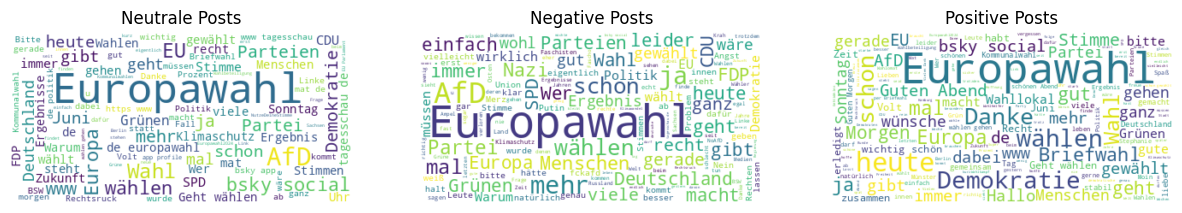

In [ ]:
# Plot word clouds side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(wordcloud_neutral, interpolation='bilinear')
axs[0].set_title('Neutrale Posts')
axs[0].axis('off')

axs[1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1].set_title('Negative Posts')
axs[1].axis('off')

axs[2].imshow(wordcloud_positive, interpolation='bilinear')
axs[2].set_title('Positive Posts')
axs[2].axis('off')


In [ ]:
axs[1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1].set_title('Negative Tweets')
axs[1].axis('off')



(-0.5, 399.5, 199.5, -0.5)

In [ ]:
axs[2].imshow(wordcloud_positive, interpolation='bilinear')
axs[2].set_title('Positive Tweets')
axs[2].axis('off')

(-0.5, 399.5, 199.5, -0.5)

In [ ]:
pipe = pipeline("text-classification", model="deepset/gbert-base", device=0) # Laden des Modells
data = load_dataset("imdb", split="test").shuffle().select(range(1000)) # Laden des Datensatzes, Wahl des test-Splits
metric = evaluate.load("accuracy") # Verwendung der Accuracy-Metrik

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/d50cb1df9660ff2de1af8a5362d322b3d5a1a28a/config.json
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--deepset--gbert-base/snapshots/d50cb1df9660ff2de1af8a5362d322b3d5a1a28a/config.json
Model config BertConfig {
 

In [ ]:
# Erstellen eines Evaluators für die Textklassifikation
evaluator_instance = evaluate.evaluator("text-classification")


# Instead of hardcoding, dynamically get the label2id mapping from the model's config
# Assuming your model (pipe) has a 'config' attribute with 'id2label' or 'label2id'
if hasattr(pipe.model.config, 'id2label'):
    id2label = pipe.model.config.id2label
elif hasattr(pipe.model.config, 'label2id'):
    # Invert label2id to get id2label if id2label is not directly available
    label2id = pipe.model.config.label2id
    id2label = {id: label for label, id in label2id.items()}
else:
    raise ValueError("Model config does not contain 'id2label' or 'label2id'")

# Create label_mapping from id2label
label_mapping = {label: id for id, label in id2label.items()}


# Durchführen der Evaluation
results = evaluator_instance.compute(
    model_or_pipeline=pipe,
    data=data,
    metric=metric,
    label_mapping=label_mapping,  # Use the generated label_mapping
)

# Ausgabe des Ergebnisses
print(results)

Disabling tokenizer parallelism, we're using DataLoader multithreading already


{'accuracy': 0.511, 'total_time_in_seconds': 23.119292364999637, 'samples_per_second': 43.25391903057997, 'latency_in_seconds': 0.023119292364999634}


In [ ]:
results = evaluator_instance.compute(
    model_or_pipeline=pipe,
    data=data,
    metric=metric,
    label_mapping=label_mapping,  # Use the model's label mapping
    strategy="bootstrap",
    n_resamples=200,
)
print(results)

{'accuracy': {'confidence_interval': (0.4822383781764753, 0.5441258862138465), 'standard_error': 0.015068500207136166, 'score': 0.511}, 'total_time_in_seconds': 21.899880790999305, 'samples_per_second': 45.66234901200891, 'latency_in_seconds': 0.021899880790999304}


In [ ]:
pipe = pipeline("text-classification", model="oliverguhr/german-sentiment-bert", device=0) # Laden des Modells
data = load_dataset("imdb", split="test").shuffle().select(range(1000)) # Laden des Datensatzes, Wahl des test-Splits
metric = evaluate.load("accuracy") # Verwendung der Accuracy-Metrik

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--oliverguhr--german-sentiment-bert/snapshots/f195511fd2678d4a56ca3f5a371844138a3bc8d9/config.json
Model config BertConfig {
  "_name_or_path": "oliverguhr/german-sentiment-bert",
  "_num_labels": 3,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "germansentiment",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vo

In [ ]:
eval = evaluator("text-classification") # Erstellen eines Evaluators für die Textklassifikation

results = eval.compute(model_or_pipeline=pipe,
                       data=data,
                       metric=metric,
                       label_mapping={"neutral" : 0, "negative": 1, "positive": 2}, # Updated label_mapping with correct keys
                       ) # Durchführen der Evaluation

print(results) # Ausgabe des Ergebnisses

{'accuracy': 0.285, 'total_time_in_seconds': 24.723917313998754, 'samples_per_second': 40.446664956034176, 'latency_in_seconds': 0.024723917313998752}


In [45]:
results = eval.compute(model_or_pipeline=pipe,
                       data=data,
                       metric=metric,
                       label_mapping={"neutral" : 0, "negative": 1, "positive": 2}, # Changed keys to lowercase
                       strategy="bootstrap", n_resamples=200)

print(results)

{'accuracy': {'confidence_interval': (0.25168101677745086, 0.30920377790783315), 'standard_error': 0.01491560765637102, 'score': 0.285}, 'total_time_in_seconds': 26.290788645999783, 'samples_per_second': 38.03613552506166, 'latency_in_seconds': 0.02629078864599978}
